# <center>Data Analysis 3 - Assignment 1: Building a prediction model on house prices</center>

Elsa Andrea Rodriguez Canales, 250008

**Dataset:** Extracted from https://insideairbnb.com/get-the-data/

**Chosen city:** Mexico City

**Date:** Q2 and Q3 2025

In [1]:
import sys
import subprocess

required_packages = ['pandas', 'numpy', 'scikit-learn', 'xgboost', 'patsy', 'statsmodels']

for package in required_packages:
    try:
        __import__(package)
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package, "--break-system-packages"])

print("✓ All dependencies installed!")

Installing scikit-learn...
✓ All dependencies installed!


In [2]:
%matplotlib inline
import warnings
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import os
import time
import sys
from patsy import dmatrices
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import math
from sklearn.metrics import root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from datetime import timedelta
import matplotlib.ticker as mtick
import xgboost as xgb
import seaborn as sns

# Part I

In [3]:
url = "https://github.com/elsaandreardz/Data-Analysis-3/raw/main/Assingment_1/raw_data/listings_cdmx_Q2.csv.gz"
cdmxQ2 = pd.read_csv(url, compression="gzip")
cdmxQ2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26401 entries, 0 to 26400
Data columns (total 79 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            26401 non-null  int64  
 1   listing_url                                   26401 non-null  object 
 2   scrape_id                                     26401 non-null  int64  
 3   last_scraped                                  26401 non-null  object 
 4   source                                        26401 non-null  object 
 5   name                                          26401 non-null  object 
 6   description                                   25633 non-null  object 
 7   neighborhood_overview                         13970 non-null  object 
 8   picture_url                                   26401 non-null  object 
 9   host_id                                       26401 non-null 

## 1. Dataset and Feature Engineering

In [4]:
to_filter=cdmxQ2.isna().sum()
to_filter[to_filter>0].sort_values(ascending = False)

license                         26401
calendar_updated                26401
neighbourhood_group_cleansed    26401
host_neighbourhood              12831
neighborhood_overview           12431
neighbourhood                   12431
host_about                      11237
host_location                    6237
host_response_time               4686
host_response_rate               4686
host_acceptance_rate             3610
review_scores_communication      3375
review_scores_accuracy           3375
review_scores_checkin            3375
review_scores_cleanliness        3375
review_scores_value              3375
review_scores_location           3375
reviews_per_month                3373
first_review                     3373
last_review                      3373
review_scores_rating             3373
beds                             3297
bathrooms                        3281
price                            3274
estimated_revenue_l365d          3274
host_is_superhost                1359
has_availabi

In [5]:
to_filter[to_filter>0].index

Index(['description', 'neighborhood_overview', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood', 'neighbourhood_group_cleansed', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'price', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'calendar_updated', 'has_availability',
       'estimated_revenue_l365d', 'first_review', 'last_review',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'license', 'reviews_per_m

In [6]:
#Transform price into numeric value
# Method 2: If price has currency symbols or commas, clean first
cdmxQ2['price'] = cdmxQ2['price'].str.replace('$', '', regex=False)
cdmxQ2['price'] = cdmxQ2['price'].str.replace(',', '', regex=False)
cdmxQ2['price'] = pd.to_numeric(cdmxQ2['price'], errors='coerce')


### Missing Values

In [7]:
# 1. drop if no target (already did)
cdmxQ2.dropna(subset=['price'], inplace = True)

# 2. imput when few, not that important
cdmxQ2['bathrooms']=cdmxQ2['bathrooms'].fillna(np.nanmedian(cdmxQ2['bathrooms'])) 
cdmxQ2['minimum_minimum_nights']=cdmxQ2['minimum_minimum_nights'].fillna(1)
cdmxQ2['reviews_per_month']=cdmxQ2['reviews_per_month'].fillna(1)

#3. Drop the column license, neighbourhood_group_cleansed and calendar_updated, as it is completely blank.
cdmxQ2 = cdmxQ2.drop('license', axis=1)
cdmxQ2 = cdmxQ2.drop('calendar_updated', axis=1)
cdmxQ2 = cdmxQ2.drop('neighbourhood_group_cleansed', axis=1)
cdmxQ2

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,35797,https://www.airbnb.com/rooms/35797,20250625031918,2025-06-26,city scrape,Villa Dante,"Dentro de Villa un estudio de arte con futon, ...","Santa Fe Shopping Mall, Interlomas Park and th...",https://a0.muscache.com/pictures/f395ab78-1185...,153786,...,NaN,NaN,NaN,NaN,f,1,1,0,0,1.00
1,44616,https://www.airbnb.com/rooms/44616,20250625031918,2025-07-01,city scrape,Condesa Haus,A new concept of hosting in mexico through a b...,NaN,https://a0.muscache.com/pictures/251410/ec75fe...,196253,...,4.87,4.78,4.98,4.47,f,9,4,2,0,0.39
2,56074,https://www.airbnb.com/rooms/56074,20250625031918,2025-07-01,city scrape,Great space in historical San Rafael,This great apartment is located in one of the ...,Very traditional neighborhood with all service...,https://a0.muscache.com/pictures/3005118/60dac...,265650,...,4.98,4.94,4.76,4.79,f,1,1,0,0,0.48
3,67703,https://www.airbnb.com/rooms/67703,20250625031918,2025-07-01,city scrape,"2 bedroom apt. deco bldg, Condesa","Comfortably furnished, sunny, 2 bedroom apt., ...",NaN,https://a0.muscache.com/pictures/3281720/6f078...,334451,...,4.94,4.92,4.98,4.92,f,2,2,0,0,0.30
4,70644,https://www.airbnb.com/rooms/70644,20250625031918,2025-07-01,city scrape,Beautiful light Studio Coyoacan- full equipped !,COYOACAN designer studio quiet & safe! well eq...,Coyoacan is a beautiful neighborhood famous fo...,https://a0.muscache.com/pictures/f397d2da-d045...,212109,...,4.96,4.98,4.96,4.92,f,3,2,1,0,0.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26396,1450299137475327273,https://www.airbnb.com/rooms/1450299137475327273,20250625031918,2025-07-01,city scrape,Central 68 Arena CDMX Aduana Pantaco Ind Vallejo,New 60-meter luxury apartment with two spaciou...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,170416107,...,4.00,5.00,4.00,5.00,t,1,1,0,0,1.00
26397,1450300528106131951,https://www.airbnb.com/rooms/1450300528106131951,20250625031918,2025-06-26,city scrape,CDMX | Business Class Flat,Experience elevated business travel in our bea...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,358250534,...,NaN,NaN,NaN,NaN,t,14,14,0,0,1.00
26398,1450345027980478127,https://www.airbnb.com/rooms/1450345027980478127,20250625031918,2025-07-01,city scrape,Corazón CDMX Roma norte/Reforma,"Apartment in the heart of Mexico City, 2 minut...",NaN,https://a0.muscache.com/pictures/hosting/Hosti...,594251711,...,NaN,NaN,NaN,NaN,f,6,3,3,0,1.00
26399,1450394952972090126,https://www.airbnb.com/rooms/1450394952972090126,20250625031918,2025-07-01,city scrape,Chic Loft + Lap Pool & Gym,Stay in a chic loft inside a restored historic...,NaN,https://a0.muscache.com/pictures/hosting/Hosti...,24161895,...,NaN,NaN,NaN,NaN,f,1,1,0,0,1.00


In [8]:
cdmxQ2 = cdmxQ2[cdmxQ2['property_type'].isin(['Entire rental unit', 'Room in hotel', 'Apartment', 'House',"Entire condo	"])]
cdmxQ2 = cdmxQ2[cdmxQ2['room_type'].isin(['Entire home/apt', 'Hotel room', 'Apartment', 'House'])]
cdmxQ2

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
3,67703,https://www.airbnb.com/rooms/67703,20250625031918,2025-07-01,city scrape,"2 bedroom apt. deco bldg, Condesa","Comfortably furnished, sunny, 2 bedroom apt., ...",NaN,https://a0.muscache.com/pictures/3281720/6f078...,334451,...,4.94,4.92,4.98,4.92,f,2,2,0,0,0.30
4,70644,https://www.airbnb.com/rooms/70644,20250625031918,2025-07-01,city scrape,Beautiful light Studio Coyoacan- full equipped !,COYOACAN designer studio quiet & safe! well eq...,Coyoacan is a beautiful neighborhood famous fo...,https://a0.muscache.com/pictures/f397d2da-d045...,212109,...,4.96,4.98,4.96,4.92,f,3,2,1,0,0.81
10,1286695,https://www.airbnb.com/rooms/1286695,20250625031918,2025-06-27,city scrape,"Comfortable, beautiful and convenient pied à t...",You are visiting one of the most exciting citi...,Polanco is one of the friendliest and safest n...,https://a0.muscache.com/pictures/a66f32b8-4cf2...,6998716,...,4.83,4.74,4.71,4.40,f,1,1,0,0,0.33
11,1288566,https://www.airbnb.com/rooms/1288566,20250625031918,2025-06-26,city scrape,Luxury Loft-Style Apartment in Vibrant Polanco...,Let the tones from the grand piano fill the hu...,Dine in dozens of restaurants and sample score...,https://a0.muscache.com/pictures/404ce369-697c...,540705,...,4.98,4.87,4.97,4.81,f,2,2,0,0,1.92
18,1411454,https://www.airbnb.com/rooms/1411454,20250625031918,2025-07-01,city scrape,Modern Suite in Roma Mansion,This lovely studio apartment is an addition to...,NaN,https://a0.muscache.com/pictures/3cbfdd60-02d6...,7609684,...,4.98,4.98,4.95,4.86,f,4,4,0,0,2.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26391,1450233077447172488,https://www.airbnb.com/rooms/1450233077447172488,20250625031918,2025-07-01,city scrape,VH | Condesa | Stylish Loft + Wifi & Rooftop |...,"At Virtual Homes, guest satisfaction is our to...",Condesa is one of Mexico City's most vibrant a...,https://a0.muscache.com/pictures/prohost-api/H...,665095287,...,NaN,NaN,NaN,NaN,t,20,20,0,0,1.00
26393,1450244485815740442,https://www.airbnb.com/rooms/1450244485815740442,20250625031918,2025-07-01,city scrape,"Coyoacan, Plaza de los Coyotes",This place has a strategic location - it will ...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,431645813,...,NaN,NaN,NaN,NaN,t,3,3,0,0,1.00
26397,1450300528106131951,https://www.airbnb.com/rooms/1450300528106131951,20250625031918,2025-06-26,city scrape,CDMX | Business Class Flat,Experience elevated business travel in our bea...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,358250534,...,NaN,NaN,NaN,NaN,t,14,14,0,0,1.00
26398,1450345027980478127,https://www.airbnb.com/rooms/1450345027980478127,20250625031918,2025-07-01,city scrape,Corazón CDMX Roma norte/Reforma,"Apartment in the heart of Mexico City, 2 minut...",NaN,https://a0.muscache.com/pictures/hosting/Hosti...,594251711,...,NaN,NaN,NaN,NaN,f,6,3,3,0,1.00


### EDA

In [9]:
#How is the average price changing in my district by `neighbourhood_group` and `room_type`?
cdmxQ2.groupby(["property_type", "room_type"]).agg(
    mean_price=("price", np.mean), 
    count = ('price', 'size')
).style.format({'mean_price': '{:,.2f}', 'count': '{:,.0f}'})

In [10]:
cdmxQ2.groupby(["room_type"]).agg(mean_price=("price", np.mean)).map('{:,.2f}'.format)

,mean_price
room_type,
Entire home/apt,"1,815.32"
Hotel room,"176,111.81"


In [11]:
cdmxQ2.price.describe().map('{:,.2f}'.format)

count      9,185.00
mean       2,403.58
std       21,130.80
min          165.00
25%          948.00
50%        1,324.00
75%        2,000.00
max      759,762.00
Name: price, dtype: object

In [12]:
# How are extreme prices distributed?
cdmxQ2.price.quantile([0.75, 0.8, 0.9, 0.95, 0.99, 0.995]).map('{:,.2f}'.format)

0.750     2,000.00
0.800     2,247.00
0.900     3,118.00
0.950     4,180.60
0.990     8,753.28
0.995    13,850.88
Name: price, dtype: object

### Variable Selection

In [13]:
# basic variables inc neighbourhood
basic_vars = [
    "accommodates",
    "beds",
    "property_type",
    "room_type",
    "bathrooms",
    "neighbourhood_cleansed",
]

# reviews
reviews = [
    "number_of_reviews",
    "review_scores_rating",
]

# interactions for the LASSO
# from ch14
X1 = [
    "accommodates:property_type",
    "room_type:property_type",
]
# with boroughs
X2 = [
    "property_type:neighbourhood_cleansed",
    "room_type:neighbourhood_cleansed",
    "accommodates:neighbourhood_cleansed",
]

# Combine all predictors
predictors = basic_vars + reviews + X1 + X2
predictors_1 = basic_vars
predictors_2 = basic_vars + reviews
predictors_E = basic_vars + reviews + X1 + X2

The first step of the data engineering process was to transform the price variable into a numeric value. To achieve this, the data was cleaned by removing the dollar symbol and commas. An analysis of missing values showed that the columns licenses, calendar updates, neighborhood, and neighborhood host contained only blank values across the entire dataset; therefore, these columns were removed. For other relevant columns with partial missing values, imputation was applied. Specifically, missing values in bathrooms were replaced with the median value, while minimum nights and reviews per month were imputed with a value of 1.

As the final step of the data engineering process, the available categories for the property type and room type variables were adjusted to be consistent with the data analyzed in class. An exploratory data analysis (EDA) was then performed on these two fields, and the main insights were examined.Based on the EDA results and a detailed review of each variable’s meaning, the final set of features was selected. The retained variables include property type, accommodates, bathrooms, and other relevant attributes, as shown in the previous code.

## 2. Predictive Modelling

### Divide the data in train/test and handle categorical columns

In [14]:
df_train, df_holdout = train_test_split(cdmxQ2, train_size=0.7, random_state = 20263101)
df_train.shape, df_holdout.shape


((6429, 76), (2756, 76))

In [15]:
# Identify categorical columns
categorical_cols = ['property_type', 'room_type', 'neighbourhood_cleansed']
categorical_cols = [col for col in categorical_cols if col in predictors]

print(f"\nCategorical columns to encode: {categorical_cols}")

# Combine train and holdout to ensure same columns after encoding
df_combined = pd.concat([df_train, df_holdout], keys=['train', 'holdout'])

# Create dummy variables
df_encoded = pd.get_dummies(df_combined, 
                            columns=categorical_cols, 
                            drop_first=True,
                            dtype=int)

# Split back into train and holdout
train_encoded = df_encoded.loc['train']
holdout_encoded = df_encoded.loc['holdout']

# Separate features and target
X_train = train_encoded.drop('price', axis=1)
y_train = train_encoded['price']

X_holdout = holdout_encoded.drop('price', axis=1)
y_holdout = holdout_encoded['price']

print(f"\nX_train shape: {X_train.shape}")
print(f"X_holdout shape: {X_holdout.shape}")
print(f"Number of features: {X_train.shape[1]}")


Categorical columns to encode: ['property_type', 'room_type', 'neighbourhood_cleansed']

X_train shape: (6429, 89)
X_holdout shape: (2756, 89)
Number of features: 89


### 1. OLS

In [16]:
y, X = dmatrices("price ~ " + " + ".join(predictors_2), df_train)

start_time = time.time()
ols_model = LinearRegression().fit(X,y)
end_time = time.time()
total_time1 = end_time - start_time
print(f"Total time: {end_time - start_time:.2f} seconds")

y_hat = ols_model.predict(X)
ols_rmse = root_mean_squared_error(y, y_hat)
ols_rmse

Total time: 0.09 seconds


2793.978350247501

In [17]:
ols_model_coeffs_df = pd.DataFrame(
    ols_model.coef_.tolist()[0],
    index=X.design_info.column_names,
    columns=["ols_coefficient"],
).assign(ols_coefficient=lambda x: x.ols_coefficient.round(3))

ols_model_coeffs_df

,ols_coefficient
Intercept,0.000
property_type[T.Room in hotel],2787.546
room_type[T.Hotel room],-3932.952
neighbourhood_cleansed[T.Benito Juárez],288.960
neighbourhood_cleansed[T.Coyoacán],406.966
neighbourhood_cleansed[T.Cuajimalpa de Morelos],397.684
neighbourhood_cleansed[T.Cuauhtémoc],892.846
neighbourhood_cleansed[T.Gustavo A. Madero],215.704
neighbourhood_cleansed[T.Iztacalco],187.131
neighbourhood_cleansed[T.Iztapalapa],22.821


### 2. LASSO

In [18]:
lasso_model =  ElasticNet(l1_ratio = 1, fit_intercept = True)

lasso_model_cv = GridSearchCV(
    lasso_model,
    # {"alpha":[i/100 for i in range(1, 26, 1)]}, #> this option takes forever to run
    {"alpha":[i/100 for i in range(5, 26, 5)]},
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

y, X = dmatrices("price ~ " + " + ".join(predictors_E), df_train)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

start_time = time.time()
lasso_model_cv.fit(X_scaled, y.ravel())
end_time = time.time()
total_time2 = end_time - start_time
print(f"Total time: {end_time - start_time:.2f} seconds")

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ....................alpha=0.05;, score=-2508.221 total time=   0.7s
[CV 2/5] END ....................alpha=0.05;, score=-1720.865 total time=   0.4s
[CV 3/5] END ....................alpha=0.05;, score=-3387.929 total time=   0.6s
[CV 4/5] END ....................alpha=0.05;, score=-4027.098 total time=   0.7s
[CV 5/5] END ....................alpha=0.05;, score=-1522.296 total time=   0.3s
[CV 1/5] END .....................alpha=0.1;, score=-2508.179 total time=   0.3s
[CV 2/5] END .....................alpha=0.1;, score=-1720.836 total time=   0.3s
[CV 3/5] END .....................alpha=0.1;, score=-3387.899 total time=   0.3s
[CV 4/5] END .....................alpha=0.1;, score=-4027.030 total time=   0.2s
[CV 5/5] END .....................alpha=0.1;, score=-1522.217 total time=   0.3s
[CV 1/5] END ....................alpha=0.15;, score=-2508.138 total time=   0.4s
[CV 2/5] END ....................alpha=0.15;, sco

In [19]:
lasso_model_cv.best_estimator_

,alpha,0.25
,l1_ratio,1
,fit_intercept,True
,precompute,False
,max_iter,1000
,copy_X,True
,tol,0.0001
,warm_start,False
,positive,False
,random_state,None
,selection,'cyclic'


In [20]:
lasso_model_cv.cv_results_

{'mean_fit_time': array([0.64114108, 0.3867836 , 0.61078944, 0.52845917, 0.2662262 ]),
 'std_fit_time': array([0.17437045, 0.06562187, 0.29914034, 0.13989601, 0.08215938]),
 'mean_score_time': array([0.00221524, 0.00192127, 0.00254555, 0.00276546, 0.00215888]),
 'std_score_time': array([0.00022703, 0.0002952 , 0.00081895, 0.00081655, 0.00023388]),
 'param_alpha': masked_array(data=[0.05, 0.1, 0.15, 0.2, 0.25],
              mask=[False, False, False, False, False],
        fill_value=1e+20),
 'params': [{'alpha': 0.05},
  {'alpha': 0.1},
  {'alpha': 0.15},
  {'alpha': 0.2},
  {'alpha': 0.25}],
 'split0_test_score': array([-2508.22052033, -2508.17909318, -2508.13831802, -2508.10110587,
        -2508.06582522]),
 'split1_test_score': array([-1720.86493901, -1720.83634394, -1720.79777809, -1720.76574521,
        -1720.73505393]),
 'split2_test_score': array([-3387.92942923, -3387.89902564, -3387.87039222, -3387.843599  ,
        -3387.81767896]),
 'split3_test_score': array([-4027.0978306

In [21]:
lasso_rmse = pd.DataFrame(lasso_model_cv.cv_results_).loc[
    lambda x: x.param_alpha == lasso_model_cv.best_estimator_.alpha
].mean_test_score.values[0] * -1
lasso_rmse

np.float64(2633.0943686390556)

### 3. Random Forest

In [22]:
y, X = dmatrices("price ~ " + " + ".join(predictors_2), df_train)
type(X)
X.shape
print('The theoretical recommended number of variables: {:.2f}.'.format(math.sqrt(len(X.design_info.column_names))))

The theoretical recommended number of variables: 4.80.


In [23]:
rfr = RandomForestRegressor(random_state = 20250224)

tune_grid = {"max_features": [6, 8, 10, 12], "min_samples_leaf": [5, 10, 15]}

rf_random = GridSearchCV(
    estimator = rfr,
    param_grid = tune_grid,
    cv = 5,
    scoring = "neg_root_mean_squared_error",
    verbose = 3,
)

start_time = time.time()
rf_model = rf_random.fit(X, y.ravel())
end_time = time.time()
total_time3 = end_time - start_time
print(f"Total time: {end_time - start_time:.2f} seconds")

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[CV 1/5] END max_features=6, min_samples_leaf=5;, score=-2548.331 total time=   1.6s
[CV 2/5] END max_features=6, min_samples_leaf=5;, score=-1758.538 total time=   1.5s
[CV 3/5] END max_features=6, min_samples_leaf=5;, score=-3381.731 total time=   1.1s
[CV 4/5] END max_features=6, min_samples_leaf=5;, score=-4062.958 total time=   1.2s
[CV 5/5] END max_features=6, min_samples_leaf=5;, score=-1531.371 total time=   1.1s
[CV 1/5] END max_features=6, min_samples_leaf=10;, score=-2514.534 total time=   0.9s
[CV 2/5] END max_features=6, min_samples_leaf=10;, score=-1731.918 total time=   1.0s
[CV 3/5] END max_features=6, min_samples_leaf=10;, score=-3387.128 total time=   0.9s
[CV 4/5] END max_features=6, min_samples_leaf=10;, score=-4051.476 total time=   0.9s
[CV 5/5] END max_features=6, min_samples_leaf=10;, score=-1543.774 total time=   0.9s
[CV 1/5] END max_features=6, min_samples_leaf=15;, score=-2513.562 total time=   0.8s
[CV 2/5] END max_features=6, min_samples_leaf=15;, score=-1

In [24]:
rf_model.cv_results_

{'mean_fit_time': array([1.34452515, 0.97312179, 0.88354621, 1.20969644, 1.0450489 ,
        0.93069077, 1.29300504, 1.08876934, 1.02583528, 1.41627631,
        1.36614828, 1.15792532]),
 'std_fit_time': array([0.19248839, 0.03535208, 0.02067157, 0.21900018, 0.15868056,
        0.10487397, 0.09034821, 0.08242575, 0.09495488, 0.08928876,
        0.14054902, 0.11529673]),
 'mean_score_time': array([0.05694056, 0.04348044, 0.04161377, 0.04291539, 0.04388738,
        0.03641162, 0.06070209, 0.03617773, 0.03474183, 0.04388423,
        0.04259248, 0.03745842]),
 'std_score_time': array([0.00926011, 0.00149003, 0.00259406, 0.0033831 , 0.00871357,
        0.00078405, 0.02971941, 0.0014123 , 0.00274052, 0.00421557,
        0.00575684, 0.00310137]),
 'param_max_features': masked_array(data=[6, 6, 6, 8, 8, 8, 10, 10, 10, 12, 12, 12],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
        fill_value=999999),
 'param_min_

In [25]:
df_rf_model_cv_results = pd.DataFrame(rf_model.cv_results_)[[
    'param_max_features', 'param_min_samples_leaf', 'mean_test_score']]
    
df_rf_model_cv_results.columns = ['max features', 'min node size', 'RMSE']
df_rf_model_cv_results

,max features,min node size,RMSE
0,6,5,-2656.585846
1,6,10,-2645.766098
2,6,15,-2646.417261
3,8,5,-2658.375524
4,8,10,-2646.814690
5,8,15,-2644.162816
6,10,5,-2666.666692
7,10,10,-2649.263304
8,10,15,-2648.707404
9,12,5,-2679.016169


In [26]:
df_rf_model_cv_results.pivot(
    index = 'max features', 
    columns = 'min node size', 
    values = 'RMSE').round(2)*-1

min node size,5,10,15
max features,,,
6,2656.59,2645.77,2646.42
8,2658.38,2646.81,2644.16
10,2666.67,2649.26,2648.71
12,2679.02,2653.59,2650.51


In [27]:
rf_model.best_score_


np.float64(-2644.162815599316)

In [28]:
rf_model.best_params_

{'max_features': 8, 'min_samples_leaf': 15}

In [29]:
rf_model.best_estimator_

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,15
,min_weight_fraction_leaf,0.0
,max_features,8
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [30]:
y_h, X_h = dmatrices("price ~ " + " + ".join(predictors_2), df_holdout)
pred = rf_model.predict(X_h)

In [31]:
print(f"X_train shape: {X.shape}")
print(f"X_holdout shape: {X_h.shape}")

X_train shape: (5805, 23)
X_holdout shape: (2482, 23)


In [32]:
rmse(y_h, pred)

array([1460.38578124, 1435.28410259, 1411.68949513, ..., 1630.87993527,
       1427.63165546, 1414.62397162], shape=(2482,))

In [33]:
#root_mean_squared_error(y_h, pred, squared= False)
random_forest_rmse = root_mean_squared_error(y_h, pred)
random_forest_rmse

1182.1586957545092

### 4. GBM

In [34]:
X_df = pd.DataFrame(X, columns=X.design_info.column_names)

preprocessor = ColumnTransformer(
    transformers=[("num", StandardScaler(), X_df.columns)]
)

pipe = Pipeline([
    ("preprocess", preprocessor),
    ("gbm", GradientBoostingRegressor(
        learning_rate=0.1,
        min_samples_split=20,
        max_features=10
    ))
])

tune_grid = {
    "gbm__n_estimators": [200, 300],
    "gbm__max_depth": [5, 10]
}

gbm_model_cv = GridSearchCV(
    pipe,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=2,
    n_jobs=1
)

start_time = time.time()
gbm_model_cv.fit(X_df, y.ravel())
end_time = time.time()
total_time4 = end_time - start_time
print(f"Total time: {end_time - start_time:.2f} seconds")

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ............gbm__max_depth=5, gbm__n_estimators=200; total time=   2.1s
[CV] END ............gbm__max_depth=5, gbm__n_estimators=200; total time=   1.4s
[CV] END ............gbm__max_depth=5, gbm__n_estimators=200; total time=   1.4s
[CV] END ............gbm__max_depth=5, gbm__n_estimators=200; total time=   1.5s
[CV] END ............gbm__max_depth=5, gbm__n_estimators=200; total time=   1.3s
[CV] END ............gbm__max_depth=5, gbm__n_estimators=300; total time=   2.2s
[CV] END ............gbm__max_depth=5, gbm__n_estimators=300; total time=   2.4s
[CV] END ............gbm__max_depth=5, gbm__n_estimators=300; total time=   2.3s
[CV] END ............gbm__max_depth=5, gbm__n_estimators=300; total time=   2.1s
[CV] END ............gbm__max_depth=5, gbm__n_estimators=300; total time=   2.2s
[CV] END ...........gbm__max_depth=10, gbm__n_estimators=200; total time=   2.6s
[CV] END ...........gbm__max_depth=10, gbm__n_est

In [35]:
gbm_model_cv.cv_results_

{'mean_fit_time': array([1.61362867, 2.28943915, 2.59591546, 3.81466031]),
 'std_fit_time': array([0.27833028, 0.09598837, 0.09024358, 0.10383328]),
 'mean_score_time': array([0.01726203, 0.02761855, 0.032373  , 0.04022779]),
 'std_score_time': array([0.0018221 , 0.00806186, 0.00225367, 0.00296299]),
 'param_gbm__max_depth': masked_array(data=[5, 5, 10, 10],
              mask=[False, False, False, False],
        fill_value=999999),
 'param_gbm__n_estimators': masked_array(data=[200, 300, 200, 300],
              mask=[False, False, False, False],
        fill_value=999999),
 'params': [{'gbm__max_depth': 5, 'gbm__n_estimators': 200},
  {'gbm__max_depth': 5, 'gbm__n_estimators': 300},
  {'gbm__max_depth': 10, 'gbm__n_estimators': 200},
  {'gbm__max_depth': 10, 'gbm__n_estimators': 300}],
 'split0_test_score': array([-3071.67983181, -2763.40725604, -3075.87780815, -3015.6169841 ]),
 'split1_test_score': array([-2226.86982837, -2370.31525997, -3666.32625656, -3879.07891252]),
 'split2_t

In [36]:
gbm_model_cv.best_estimator_

,steps,"[('preprocess', ...), ('gbm', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [37]:
gbm_rmse = gbm_model_cv.best_score_*-1

In [38]:
gbm_rmse

np.float64(2928.2417139440945)

### 5. XGBoost

In [39]:
# XGBoost model
xgb_model = xgb.XGBRegressor(
    random_state=20250224,
    tree_method='hist',  # Faster training
    objective='reg:squarederror'
)

# Grid search parameters for XGBoost
tune_grid = {
    "n_estimators": [200, 300],
    "learning_rate": [0.05, 0.1],
    "max_depth": [5, 7],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

xgb_model_cv = GridSearchCV(
    xgb_model,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
    n_jobs=1
)

start_time = time.time()
xgb_model = xgb_model_cv.fit(X, y.ravel())
end_time = time.time()
total_time5 = end_time - start_time
print(f"Total time: {end_time - start_time:.2f} seconds")

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[CV 1/5] END colsample_bytree=0.8, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.8;, score=-2665.960 total time=   1.1s
[CV 2/5] END colsample_bytree=0.8, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.8;, score=-2522.052 total time=   1.0s
[CV 3/5] END colsample_bytree=0.8, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.8;, score=-3370.434 total time=   0.4s
[CV 4/5] END colsample_bytree=0.8, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.8;, score=-4188.061 total time=   0.3s
[CV 5/5] END colsample_bytree=0.8, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.8;, score=-1769.547 total time=   0.3s
[CV 1/5] END colsample_bytree=0.8, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=1.0;, score=-2535.207 total time=   0.2s
[CV 2/5] END colsample_bytree=0.8, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=1.0;, score=-2110.082 total time=   0.2s
[CV 3/5] END colsample_bytree=0.8, learni

In [40]:
df_xgb_model_cv_results = pd.DataFrame(xgb_model_cv.cv_results_)[[
    'param_n_estimators', 'param_learning_rate', 'param_max_depth', 
    'param_subsample', 'param_colsample_bytree', 'mean_test_score']]

In [41]:
xgb_model_cv.best_estimator_

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [42]:
xgb_rmse = xgb_model_cv.best_score_*-1

In [43]:
xgb_rmse

np.float64(2790.422850802318)

## 3. Comparing Models

In [44]:
pd.DataFrame({'Model': ['OLS', 'LASSO', 'Random Forest', 'GBM','XGB'],
              'CV RMSE': [ols_rmse, lasso_rmse, random_forest_rmse, gbm_rmse, xgb_rmse]}).round(2)

,Model,CV RMSE
0,OLS,2793.98
1,LASSO,2633.09
2,Random Forest,1182.16
3,GBM,2928.24
4,XGB,2790.42


In [45]:
def format_time(seconds):
    return str(timedelta(seconds=round(seconds)))

time_results = pd.DataFrame({
    'Model': ['OLS', 'LASSO', 'Random Forest', 'GBM', 'XGB'],
    'Runtime': [format_time(s) for s in [total_time1, total_time2, total_time3, total_time4, total_time5]]})

time_results

,Model,Runtime
0,OLS,0:00:00
1,LASSO,0:00:12
2,Random Forest,0:01:12
3,GBM,0:00:54
4,XGB,0:01:52


The results of the table compares the predictive performance of several models using Root Mean Squared Error (RMSE). Lower RMSE values indicate better predictive accuracy, therefore the Random Forest achieved the best performance, with the lowest RMSE (1182.16), indicating it captures nonlinear relationships in the data more effectively than the other models.

LASSO performed second best (2633), improving upon the baseline linear regression by applying regularization and feature selection. OLS (2794) provided a reasonable baseline but was outperformed by others models. XGBoost and Gradient Boosting Machine (GBM) showed the weakest performance, with RMSE values of approximately 2790 and 2895, respectively, suggesting potential overfitting or suboptimal hyperparameter tuning.

Regarding the runtime performance, OLS was the fastest model, completing in approximately 0.01 seconds, reflecting its low computational complexity and efficiency. LASSO required slightly more time (0.12 seconds) due to the additional cost of regularization and parameter optimization. Random Forest showed a moderate runtime (1.04 seconds), which is expected given the need to train multiple decision trees. GBM and XGBoost (XGB) were the most computationally expensive, each taking approximately 51 seconds, due to their iterative boosting processes and more complex training procedures.

The OLS model serves as a useful benchmark for comparison. However, its higher RMSE relative to Random Forest and LASSO suggests that the relationship between predictors and price is likely nonlinear and benefits from either regularization or tree-based methods.

## 4. Comparing Random Forest and a GBM: Feature Importance



### a) Random Forest

In [46]:
rf_model.best_estimator_.feature_importances_

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 8.25874315e-03,
       6.95066945e-04, 2.44216001e-04, 4.47785753e-02, 5.46814235e-04,
       9.21634188e-05, 1.59013913e-04, 0.00000000e+00, 5.14317564e-02,
       0.00000000e+00, 5.15661378e-04, 0.00000000e+00, 3.11300436e-03,
       0.00000000e+00, 3.86756562e-04, 1.48185923e-01, 7.05924728e-02,
       4.01741610e-01, 1.07399363e-01, 1.61858859e-01])

In [47]:
pd.DataFrame(
    rf_model.best_estimator_.feature_importances_, 
    X.design_info.column_names)

,0
Intercept,0.000000
property_type[T.Room in hotel],0.000000
room_type[T.Hotel room],0.000000
neighbourhood_cleansed[T.Benito Juárez],0.008259
neighbourhood_cleansed[T.Coyoacán],0.000695
neighbourhood_cleansed[T.Cuajimalpa de Morelos],0.000244
neighbourhood_cleansed[T.Cuauhtémoc],0.044779
neighbourhood_cleansed[T.Gustavo A. Madero],0.000547
neighbourhood_cleansed[T.Iztacalco],0.000092
neighbourhood_cleansed[T.Iztapalapa],0.000159


In [48]:
df_var_imp = pd.DataFrame(
    rf_model.best_estimator_.feature_importances_, 
    X.design_info.column_names)\
    .reset_index()\
    .rename({"index": "variable", 0: "imp"}, axis=1)\
    .sort_values(by=["imp"], ascending=False)\
    .reset_index(drop = True)

df_var_imp['cumulative_imp'] = df_var_imp['imp'].cumsum()

df_var_imp.style.format({
    'imp': lambda x: f'{x:,.1%}',
    'cumulative_imp': lambda x: f'{x:,.1%}'})

,variable,imp,cumulative_imp
0,bathrooms,40.2%,40.2%
1,review_scores_rating,16.2%,56.4%
2,accommodates,14.8%,71.2%
3,number_of_reviews,10.7%,81.9%
4,beds,7.1%,89.0%
5,neighbourhood_cleansed[T.Miguel Hidalgo],5.1%,94.1%
6,neighbourhood_cleansed[T.Cuauhtémoc],4.5%,98.6%
7,neighbourhood_cleansed[T.Benito Juárez],0.8%,99.4%
8,neighbourhood_cleansed[T.Venustiano Carranza],0.3%,99.7%
9,neighbourhood_cleansed[T.Coyoacán],0.1%,99.8%


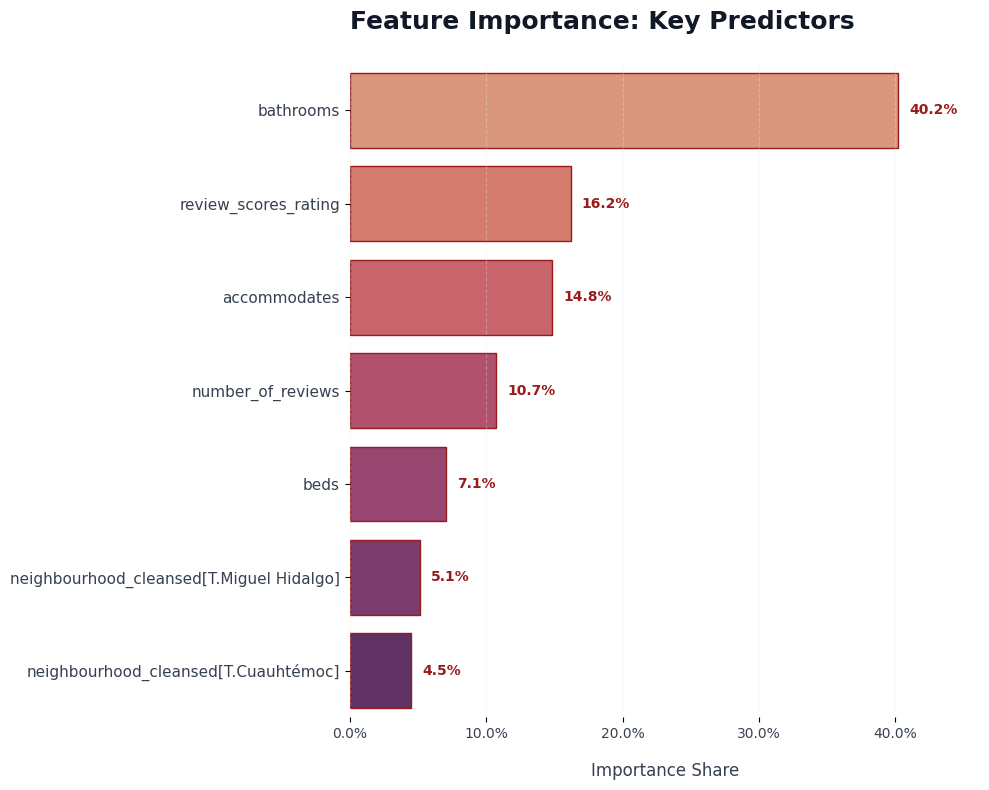

In [49]:
plot_df = df_var_imp[['variable', 'imp']].copy()
cutoff = 0.01
plot_df = plot_df[plot_df['imp'] > cutoff].sort_values(by='imp', ascending=False)

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
fig, ax = plt.subplots(figsize=(10, 8))

sns.barplot(
    data=plot_df, 
    x='imp', 
    y='variable', 
    palette="flare", 
    hue='variable',
    legend=False,
    edgecolor="#991b1b",
    linewidth=1
)

for p in ax.patches:
    width = p.get_width()
    if width > 0:
        ax.annotate(
            f'{width:.1%}', 
            (width, p.get_y() + p.get_height() / 2.), 
            ha='left', 
            va='center', 
            xytext=(8, 0), # 8 points horizontal offset
            textcoords='offset points',
            fontsize=10,
            fontweight='bold',
            color='#991b1b'
        )

plt.title('Feature Importance: Key Predictors', 
          fontsize=18, fontweight='bold', color='#111827', loc='left', pad=25)

plt.xlabel('Importance Share', fontsize=12, color='#374151', labelpad=15)
plt.ylabel('') 

ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
ax.set_xlim(0, plot_df['imp'].max() * 1.15) 
plt.yticks(fontsize=11, color='#374151')
plt.xticks(fontsize=10, color='#374151')
sns.despine(left=True, bottom=True)
plt.grid(axis='x', linestyle='--', alpha=0.3, color='#e5e7eb')
plt.tight_layout()
plt.show()

### b) GBM

In [50]:
importances = gbm_model_cv.best_estimator_.named_steps["gbm"].feature_importances_
feature_names = gbm_model_cv.best_estimator_.named_steps["preprocess"].get_feature_names_out()

In [51]:
df_var_imp_gbm = pd.DataFrame({
    "variable": feature_names,
    "imp": importances
}).sort_values("imp", ascending=False).reset_index(drop = True)

df_var_imp_gbm["cumulative_importance"] = df_var_imp_gbm["imp"].cumsum()
df_var_imp_gbm.head(10)

,variable,imp,cumulative_importance
0,num__review_scores_rating,0.300021,0.300021
1,num__bathrooms,0.298397,0.598418
2,num__number_of_reviews,0.164280,0.762699
3,num__accommodates,0.089514,0.852212
4,num__beds,0.080327,0.932539
5,num__neighbourhood_cleansed[T.Miguel Hidalgo],0.026190,0.958729
6,num__neighbourhood_cleansed[T.Cuauhtémoc],0.022705,0.981434
7,num__neighbourhood_cleansed[T.Benito Juárez],0.009245,0.990679
8,num__neighbourhood_cleansed[T.Venustiano Carra...,0.003410,0.994089
9,num__room_type[T.Hotel room],0.001598,0.995687


In [52]:
df_var_imp_gbm.style.format({
    'imp': lambda x: f'{x:,.1%}',
    'cumulative_imp': lambda x: f'{x:,.1%}'})

,variable,imp,cumulative_importance
0,num__review_scores_rating,30.0%,0.300021
1,num__bathrooms,29.8%,0.598418
2,num__number_of_reviews,16.4%,0.762699
3,num__accommodates,9.0%,0.852212
4,num__beds,8.0%,0.932539
5,num__neighbourhood_cleansed[T.Miguel Hidalgo],2.6%,0.958729
6,num__neighbourhood_cleansed[T.Cuauhtémoc],2.3%,0.981434
7,num__neighbourhood_cleansed[T.Benito Juárez],0.9%,0.990679
8,num__neighbourhood_cleansed[T.Venustiano Carranza],0.3%,0.994089
9,num__room_type[T.Hotel room],0.2%,0.995687


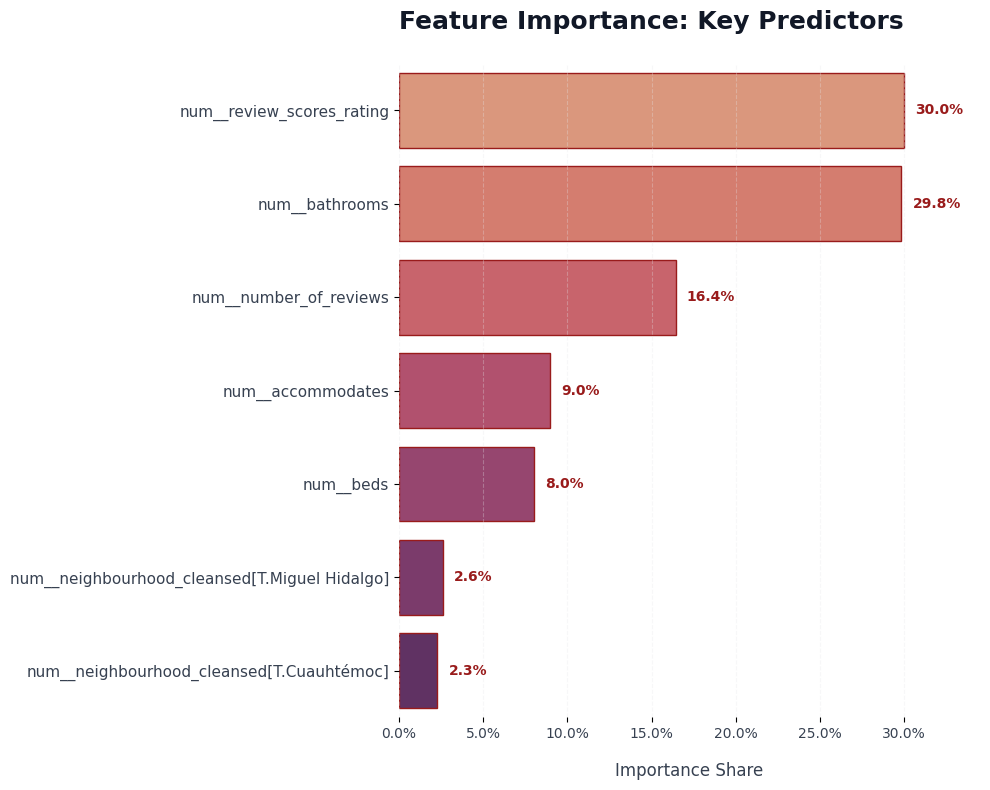

In [53]:

plot_df = df_var_imp_gbm[['variable', 'imp']].copy()
cutoff = 0.01
plot_df = plot_df[plot_df['imp'] > cutoff].sort_values(by='imp', ascending=False)

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
fig, ax = plt.subplots(figsize=(10, 8))

sns.barplot(
    data=plot_df, 
    x='imp', 
    y='variable', 
    palette="flare", 
    hue='variable',
    legend=False,
    edgecolor="#991b1b",
    linewidth=1
)

for p in ax.patches:
    width = p.get_width()
    if width > 0:
        ax.annotate(
            f'{width:.1%}', 
            (width, p.get_y() + p.get_height() / 2.), 
            ha='left', 
            va='center', 
            xytext=(8, 0), # 8 points horizontal offset
            textcoords='offset points',
            fontsize=10,
            fontweight='bold',
            color='#991b1b'
        )

plt.title('Feature Importance: Key Predictors', 
          fontsize=18, fontweight='bold', color='#111827', loc='left', pad=25)

plt.xlabel('Importance Share', fontsize=12, color='#374151', labelpad=15)
plt.ylabel('') 

ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
ax.set_xlim(0, plot_df['imp'].max() * 1.15) 
plt.yticks(fontsize=11, color='#374151')
plt.xticks(fontsize=10, color='#374151')
sns.despine(left=True, bottom=True)
plt.grid(axis='x', linestyle='--', alpha=0.3, color='#e5e7eb')
plt.tight_layout()
plt.show()

### Summary of Comparison

In [54]:
#merge the datasets
comparison = pd.merge(df_var_imp, df_var_imp_gbm, left_index=True, right_index=True)
#clean table
comparison = comparison[['variable_x', 'imp_x', 'variable_y', 'imp_y']]
comparison.columns = ['Random Forest', 'Importance_RF', 'GBM', 'Importance_GBM']
top_10_comparison = comparison.head(10)
#formating
styled_table = top_10_comparison.style.format({
    'Importance_RF': '{:.2%}',
    'Importance_GBM': '{:.2%}'
}).background_gradient(
    cmap='flare', 
    subset=['Importance_RF', 'Importance_GBM']
).set_caption("Top 10 Feature Importance Comparison: Random Forest vs GBM")

styled_table

,Random Forest,Importance_RF,GBM,Importance_GBM
0,bathrooms,40.17%,num__review_scores_rating,30.00%
1,review_scores_rating,16.19%,num__bathrooms,29.84%
2,accommodates,14.82%,num__number_of_reviews,16.43%
3,number_of_reviews,10.74%,num__accommodates,8.95%
4,beds,7.06%,num__beds,8.03%
5,neighbourhood_cleansed[T.Miguel Hidalgo],5.14%,num__neighbourhood_cleansed[T.Miguel Hidalgo],2.62%
6,neighbourhood_cleansed[T.Cuauhtémoc],4.48%,num__neighbourhood_cleansed[T.Cuauhtémoc],2.27%
7,neighbourhood_cleansed[T.Benito Juárez],0.83%,num__neighbourhood_cleansed[T.Benito Juárez],0.92%
8,neighbourhood_cleansed[T.Venustiano Carranza],0.31%,num__neighbourhood_cleansed[T.Venustiano Carranza],0.34%
9,neighbourhood_cleansed[T.Coyoacán],0.07%,num__room_type[T.Hotel room],0.16%


On the selected models, bathrooms (Random Forest) and review_scores_rating (GBM) emerged as the most influential predictors, each contributing around 40% of the total importance. This highlights the strong impact of property quality and guest satisfaction on price. Accommodation capacity–related variables (accommodates, number of reviews, and beds) ranked consistently high across both models, indicating that listing size and popularity play a key role in determining price for the airbnbs in Mexico City.

Review scores rating was particularly influential in the Random Forest model (~16%), while GBM placed more emphasis on number of bathrooms (~23%), suggesting slight differences in how each algorithm captures nonlinear effects.Neighborhood effects were present in both models but contributed relatively less to overall importance. Specific neighborhoods such as Miguel Hidalgo and Cuauhtémoc appeared consistently, though with modest importance values. Room type appeared only in the GBM top 10 features, with minimal contribution, suggesting a secondary role compared to structural and review-related attributes.

It is interesting to note that the top two variables are the same for both models but appear in opposite order. This difference can be explained by the distinct ways Random Forest and GBM measure feature importance and capture nonlinear relationships. While both models identify the same key drivers of price, the relative ranking reflects how each algorithm prioritizes splits and interactions during training rather than a fundamental disagreement about variable relevance.

# Part II

### Data Wrangling Dataset A

In [55]:
#Import dataset
url2 = "https://github.com/elsaandreardz/Data-Analysis-3/raw/main/Assingment_1/raw_data/listings_cdmx_Q3.csv.gz"
cdmxQ3 = pd.read_csv(url2, compression="gzip")
cdmxQ3.info()

#1. Identify missing values
to_filter=cdmxQ3.isna().sum()
to_filter[to_filter>0].sort_values(ascending = False)

#2. Transform price into numeric value
cdmxQ3['price'] = cdmxQ3['price'].str.replace('$', '', regex=False)
cdmxQ3['price'] = cdmxQ3['price'].str.replace(',', '', regex=False)
cdmxQ3['price'] = pd.to_numeric(cdmxQ3['price'], errors='coerce')

#3. imput when few, not that important
cdmxQ3['bathrooms']=cdmxQ3['bathrooms'].fillna(np.nanmedian(cdmxQ3['bathrooms'])) # !!! compute the median along the specified axis, while ignoring NaNs.
cdmxQ3['minimum_minimum_nights']=cdmxQ3['minimum_minimum_nights'].fillna(1)
cdmxQ3['reviews_per_month']=cdmxQ3['reviews_per_month'].fillna(1)

#4. drop if no target (already did)
cdmxQ3.dropna(subset=['price'], inplace = True)

#5. imput when few, not that important
cdmxQ3['bathrooms']=cdmxQ3['bathrooms'].fillna(np.nanmedian(cdmxQ3['bathrooms'])) # !!! compute the median along the specified axis, while ignoring NaNs.
cdmxQ3['minimum_minimum_nights']=cdmxQ3['minimum_minimum_nights'].fillna(1)
cdmxQ3['reviews_per_month']=cdmxQ3['reviews_per_month'].fillna(1)

#6. Drop the column license, neighbourhood_group_cleansed and calendar_updated, as it is completely blank.
cdmxQ3 = cdmxQ3.drop('license', axis=1)
cdmxQ3 = cdmxQ3.drop('calendar_updated', axis=1)
cdmxQ3 = cdmxQ3.drop('neighbourhood_group_cleansed', axis=1)
cdmxQ3 = cdmxQ3[cdmxQ3['property_type'].isin(['Entire rental unit', 'Room in hotel', 'Apartment', 'House',"Entire condo	"])]
cdmxQ3 = cdmxQ3[cdmxQ3['room_type'].isin(['Entire home/apt', 'Hotel room', 'Apartment', 'House'])]
cdmxQ3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27051 entries, 0 to 27050
Data columns (total 79 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            27051 non-null  int64  
 1   listing_url                                   27051 non-null  object 
 2   scrape_id                                     27051 non-null  int64  
 3   last_scraped                                  27051 non-null  object 
 4   source                                        27051 non-null  object 
 5   name                                          27051 non-null  object 
 6   description                                   26309 non-null  object 
 7   neighborhood_overview                         13736 non-null  object 
 8   picture_url                                   27051 non-null  object 
 9   host_id                                       27051 non-null 

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
12,204887,https://www.airbnb.com/rooms/204887,20250927041820,2025-09-28,city scrape,"Traditional neighborhood: Escandón, Condesa & ...",Make yourself at home in this apartment in a q...,The neighborhood is very well located and easy...,https://a0.muscache.com/pictures/9547599/67426...,998053,...,4.81,4.87,4.97,4.52,f,1,1,0,0,0.20
13,245507,https://www.airbnb.com/rooms/245507,20250927041820,2025-09-28,city scrape,Reforma Ave area / US Embassy / walk everywhere,"THE APARTMENT IS LOCATED IN A PRIME LOCATION, ...",NaN,https://a0.muscache.com/pictures/hosting/Hosti...,1288063,...,4.95,4.94,4.89,4.83,f,4,4,0,0,2.43
15,247543,https://www.airbnb.com/rooms/247543,20250927041820,2025-09-28,city scrape,"Independent studio, top location",IDEAL FOR SINGLE TRAVELER<br />SEPARATE ENTRAN...,NaN,https://a0.muscache.com/pictures/2348218/fb0d3...,1297488,...,4.95,4.94,4.98,4.93,f,2,2,0,0,0.97
17,261897,https://www.airbnb.com/rooms/261897,20250927041820,2025-09-28,city scrape,Charming 1 bedroom loft w/ balcony in Roma/con...,A 15 year old reconverted project comprising 1...,NOTE: See my guidebook for all local tips and ...,https://a0.muscache.com/pictures/7ad77bc2-85ac...,1373924,...,4.75,4.82,4.94,4.81,f,1,1,0,0,2.12
29,362583,https://www.airbnb.com/rooms/362583,20250927041820,2025-09-28,city scrape,Spacious Modern Apt. with Parking Near Reforma...,Our spacious 2 bedroom apt. is luxurious & com...,"Our neighborhood, Colonia Cuauhtémoc, is the i...",https://a0.muscache.com/pictures/6166698/0dc7c...,1832239,...,4.74,4.84,4.94,4.88,f,1,1,0,0,0.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27043,1518257575420839432,https://www.airbnb.com/rooms/1518257575420839432,20250927041820,2025-09-28,city scrape,Stay in Roma Norte's 2BR/2BA apt with Red Kitchen,Cook in the red kitchen of this apartment. <br...,NaN,https://a0.muscache.com/pictures/hosting/Hosti...,355750680,...,NaN,NaN,NaN,NaN,t,13,13,0,0,1.00
27045,1518348422274177191,https://www.airbnb.com/rooms/1518348422274177191,20250927041820,2025-09-28,city scrape,"Hermoso, cómodo, silencioso y cercano a todo.","An excellent option to rest, work and spend se...",NaN,https://a0.muscache.com/pictures/hosting/Hosti...,188587763,...,NaN,NaN,NaN,NaN,f,1,1,0,0,1.00
27048,1518433354720281854,https://www.airbnb.com/rooms/1518433354720281854,20250927041820,2025-09-28,city scrape,Espacioso departamento en Anzures,"Beautiful apartment a few blocks from Polanco,...",NaN,https://a0.muscache.com/pictures/hosting/Hosti...,470800231,...,NaN,NaN,NaN,NaN,t,20,15,5,0,1.00
27049,1518462568893975567,https://www.airbnb.com/rooms/1518462568893975567,20250927041820,2025-09-28,city scrape,Casa Roma Baja 05,It is a mini apartment with an independent ent...,NaN,https://a0.muscache.com/pictures/hosting/Hosti...,710857718,...,NaN,NaN,NaN,NaN,f,7,2,5,0,1.00


### Data Wrangling Dataset B

In [56]:
#Import dataset
url3 = "https://github.com/elsaandreardz/Data-Analysis-3/raw/main/Assingment_1/raw_data/listings_SanMateo_Q3.csv.gz"
SMQ3 = pd.read_csv(url3, compression="gzip")
SMQ3.info()

#1. Identify missing values
to_filter=SMQ3.isna().sum()
to_filter[to_filter>0].sort_values(ascending = False)

#2. Transform price into numeric value
SMQ3['price'] = SMQ3['price'].str.replace('$', '', regex=False)
SMQ3['price'] = SMQ3['price'].str.replace(',', '', regex=False)
SMQ3['price'] = pd.to_numeric(SMQ3['price'], errors='coerce')

#3. imput when few, not that important
SMQ3['bathrooms']=SMQ3['bathrooms'].fillna(np.nanmedian(SMQ3['bathrooms'])) # !!! compute the median along the specified axis, while ignoring NaNs.
SMQ3['minimum_minimum_nights']=SMQ3['minimum_minimum_nights'].fillna(1)
SMQ3['reviews_per_month']=SMQ3['reviews_per_month'].fillna(1)

#4. drop if no target (already did)
SMQ3.dropna(subset=['price'], inplace = True)

#5. imput when few, not that important
SMQ3['bathrooms']=SMQ3['bathrooms'].fillna(np.nanmedian(SMQ3['bathrooms'])) # !!! compute the median along the specified axis, while ignoring NaNs.
SMQ3['minimum_minimum_nights']=SMQ3['minimum_minimum_nights'].fillna(1)
SMQ3['reviews_per_month']=SMQ3['reviews_per_month'].fillna(1)

#6. Drop the column license, neighbourhood_group_cleansed and calendar_updated, as it is completely blank.
SMQ3 = SMQ3.drop('license', axis=1)
SMQ3 = SMQ3.drop('calendar_updated', axis=1)
SMQ3 = SMQ3.drop('neighbourhood_group_cleansed', axis=1)
SMQ3 = SMQ3[SMQ3['property_type'].isin(['Entire rental unit', 'Room in hotel', 'Apartment', 'House',"Entire condo "])]
SMQ3 = SMQ3[SMQ3['room_type'].isin(['Entire home/apt', 'Hotel room', 'Apartment', 'House'])]
SMQ3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3516 entries, 0 to 3515
Data columns (total 79 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            3516 non-null   int64  
 1   listing_url                                   3516 non-null   object 
 2   scrape_id                                     3516 non-null   int64  
 3   last_scraped                                  3516 non-null   object 
 4   source                                        3516 non-null   object 
 5   name                                          3516 non-null   object 
 6   description                                   3467 non-null   object 
 7   neighborhood_overview                         1732 non-null   object 
 8   picture_url                                   3516 non-null   object 
 9   host_id                                       3516 non-null   i

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
30,955458,https://www.airbnb.com/rooms/955458,20250925033040,2025-09-25,city scrape,Cozy Studio Apt in Ideal Location,"You'll love retreating to this comfortable, pr...","Atherton, California is a quiet, safe communit...",https://a0.muscache.com/pictures/miso/Hosting-...,5190612,...,5.00,5.00,5.00,4.90,f,1,1,0,0,0.79
39,1270828,https://www.airbnb.com/rooms/1270828,20250925033040,2025-09-25,city scrape,Home away from home in wonderful Burlingame,It's my honor to be your host and I will try t...,We love our neighborhood because it is close t...,https://a0.muscache.com/pictures/19153637/64a0...,4069703,...,4.98,4.99,4.97,4.92,f,1,1,0,0,3.04
60,2299551,https://www.airbnb.com/rooms/2299551,20250925033040,2025-09-25,city scrape,Luxury 1 br Condo near Stanford,"Luxury, Spacious 800 sq. ft , bedroom condo i...",We like the rare combination of quietness of o...,https://a0.muscache.com/pictures/30841517/3458...,10789323,...,4.75,4.42,4.71,4.63,f,1,1,0,0,0.18
63,2566174,https://www.airbnb.com/rooms/2566174,20250925033040,2025-09-25,city scrape,Charming Oceanview Moss Beach,NEW: Enhanced cleaning protocol in place!<br /...,Seal Cove is named for the adjacent seal habit...,https://a0.muscache.com/pictures/3658de29-4cdd...,11487122,...,4.97,4.95,4.97,4.78,f,1,1,0,0,2.37
91,4259057,https://www.airbnb.com/rooms/4259057,20250925033040,2025-09-25,city scrape,"2BR 2BA modern apt near Faceb, Stan","Enjoy the space, comfort and location of a sui...",The neighborhood is residential. It has other ...,https://a0.muscache.com/pictures/c53a4927-a9df...,1103761,...,4.86,4.92,4.60,4.79,t,1,1,0,0,0.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3505,1513707403798353734,https://www.airbnb.com/rooms/1513707403798353734,20250925033040,2025-09-25,city scrape,2 Queen Rooms | Stay w/ Pool & Free Parking,A perfect family-friendly choice near Half Moo...,Mori Point - 1.1 mi<br />Pacifica State Beach ...,https://a0.muscache.com/pictures/prohost-api/H...,699580416,...,NaN,NaN,NaN,NaN,t,21,0,0,0,1.00
3506,1513707410187891786,https://www.airbnb.com/rooms/1513707410187891786,20250925033040,2025-09-25,city scrape,2 Courtyard View Rooms | Lighthouse | Free Par...,A perfect family-friendly choice near Half Moo...,Mori Point - 1.1 mi<br />Pacifica State Beach ...,https://a0.muscache.com/pictures/prohost-api/H...,699580416,...,NaN,NaN,NaN,NaN,t,21,0,0,0,1.00
3510,1515395510872074248,https://www.airbnb.com/rooms/1515395510872074248,20250925033040,2025-09-25,city scrape,Quaint Apartment & King Bed Near Burlingame,"Cozy, functional space near downtown Burlingam...",NaN,https://a0.muscache.com/pictures/hosting/Hosti...,151838706,...,NaN,NaN,NaN,NaN,t,4,4,0,0,1.00
3511,1515407735551864575,https://www.airbnb.com/rooms/1515407735551864575,20250925033040,2025-09-25,city scrape,Inviting Apartment & King Bed Near Burlingame,"Cozy, functional space near downtown Burlingam...",NaN,https://a0.muscache.com/pictures/hosting/Hosti...,151838706,...,NaN,NaN,NaN,NaN,t,4,4,0,0,1.00


### Modelling Dataset A

In [ ]:
#Train/Test
df_train, df_holdout = train_test_split(cdmxQ3, train_size=0.7, random_state = 20263101)
df_train.shape, df_holdout.shape

#OLS
y, X = dmatrices("price ~ " + " + ".join(predictors_2), df_train)
start_time = time.time()
ols_model = LinearRegression().fit(X,y)
end_time = time.time()
total_time1 = end_time - start_time
print(f"Total time: {end_time - start_time:.2f} seconds")
y_hat = ols_model.predict(X)
ols_rmse_A = root_mean_squared_error(y, y_hat)
ols_rmse_A

#LASSO
lasso_model =  ElasticNet(l1_ratio = 1, fit_intercept = True)
lasso_model_cv = GridSearchCV(
    lasso_model,
    {"alpha":[i/100 for i in range(5, 26, 5)]},
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)
y, X = dmatrices("price ~ " + " + ".join(predictors_E), df_train)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
start_time = time.time()
lasso_model_cv.fit(X_scaled, y.ravel())
end_time = time.time()
total_time2 = end_time - start_time
print(f"Total time: {end_time - start_time:.2f} seconds")
lasso_model_cv.best_estimator_
lasso_model_cv.cv_results_
lasso_rmse_A = pd.DataFrame(lasso_model_cv.cv_results_).loc[
    lambda x: x.param_alpha == lasso_model_cv.best_estimator_.alpha
].mean_test_score.values[0] * -1
lasso_rmse_A

#Random Forest -------------------------------------
y, X = dmatrices("price ~ " + " + ".join(predictors_2), df_train)
type(X)
X.shape
print('The theoretical recommended number of variables: {:.2f}.'.format(math.sqrt(len(X.design_info.column_names))))
rfr = RandomForestRegressor(random_state = 20250224)
tune_grid = {"max_features": [6, 8, 10, 12], "min_samples_leaf": [5, 10, 15]}
rf_random = GridSearchCV(
    estimator = rfr,
    param_grid = tune_grid,
    cv = 5,
    scoring = "neg_root_mean_squared_error",
    verbose = 3,
)
start_time = time.time()
rf_model = rf_random.fit(X, y.ravel())
end_time = time.time()
total_time3 = end_time - start_time
print(f"Total time: {end_time - start_time:.2f} seconds")
rf_model.cv_results_
df_rf_model_cv_results = pd.DataFrame(rf_model.cv_results_)[[
    'param_max_features', 'param_min_samples_leaf', 'mean_test_score']]
df_rf_model_cv_results.columns = ['max features', 'min node size', 'RMSE']
df_rf_model_cv_results
df_rf_model_cv_results.pivot(
    index = 'max features', 
    columns = 'min node size', 
    values = 'RMSE').round(2)*-1
rf_model.best_score_
rf_model.best_params_
rf_model.best_estimator_
y_h, X_h = dmatrices("price ~ " + " + ".join(predictors_2),
                   df_holdout,
                   return_type='dataframe')
X_h = X_h.reindex(columns=X.design_info.column_names, fill_value=0)
pred = rf_model.predict(X_h)
rmse(y_h, pred)
random_forest_rmse_A = root_mean_squared_error(y_h, pred)
random_forest_rmse_A

#GBM -------------------------------------
X_df = pd.DataFrame(X, columns=X.design_info.column_names)
preprocessor = ColumnTransformer(
    transformers=[("num", StandardScaler(), X_df.columns)]
)
pipe = Pipeline([
    ("preprocess", preprocessor),
    ("gbm", GradientBoostingRegressor(
        learning_rate=0.1,
        min_samples_split=20,
        max_features=10
    ))
])
tune_grid = {
    "gbm__n_estimators": [200, 300],
    "gbm__max_depth": [5, 10]
}
gbm_model_cv = GridSearchCV(
    pipe,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=2,
    n_jobs=1
)
start_time = time.time()
gbm_model_cv.fit(X_df, y.ravel())
end_time = time.time()
total_time4 = end_time - start_time
print(f"Total time: {end_time - start_time:.2f} seconds")
gbm_model_cv.cv_results_
gbm_model_cv.best_estimator_
gbm_rmse_A = gbm_model_cv.best_score_*-1
gbm_rmse_A

#XGBoost-------------------------------------
xgb_model = xgb.XGBRegressor(
    random_state=20250224,
    tree_method='hist',  # Faster training
    objective='reg:squarederror'
)

tune_grid = {
    "n_estimators": [200, 300],
    "learning_rate": [0.05, 0.1],
    "max_depth": [5, 7],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

xgb_model_cv = GridSearchCV(
    xgb_model,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
    n_jobs=1
)

start_time = time.time()
xgb_model = xgb_model_cv.fit(X, y.ravel())
end_time = time.time()
total_time5 = end_time - start_time
print(f"Total time: {end_time - start_time:.2f} seconds")

df_xgb_model_cv_results = pd.DataFrame(xgb_model_cv.cv_results_)[[
    'param_n_estimators', 'param_learning_rate', 'param_max_depth', 
    'param_subsample', 'param_colsample_bytree', 'mean_test_score']]

xgb_model_cv.best_estimator_
xgb_rmse_A = xgb_model_cv.best_score_*-1
xgb_rmse_A

Total time: 0.01 seconds
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ....................alpha=0.05;, score=-1060.051 total time=   0.4s
[CV 2/5] END ....................alpha=0.05;, score=-1589.281 total time=   0.4s
[CV 3/5] END ....................alpha=0.05;, score=-5079.479 total time=   0.3s
[CV 4/5] END ....................alpha=0.05;, score=-2108.776 total time=   0.3s
[CV 5/5] END ....................alpha=0.05;, score=-1156.575 total time=   0.3s
[CV 1/5] END .....................alpha=0.1;, score=-1059.950 total time=   0.3s
[CV 2/5] END .....................alpha=0.1;, score=-1588.980 total time=   0.3s
[CV 3/5] END .....................alpha=0.1;, score=-5079.479 total time=   0.3s
[CV 4/5] END .....................alpha=0.1;, score=-2108.783 total time=   0.4s
[CV 5/5] END .....................alpha=0.1;, score=-1156.192 total time=   0.5s
[CV 1/5] END ....................alpha=0.15;, score=-1059.852 total time=   0.5s
[CV 2/5] END ...........

### Modelling Dataset B

In [ ]:
#Train/Test-------------------------------------
df_train, df_holdout = train_test_split(SMQ3, train_size=0.7, random_state = 20263101)
df_train.shape, df_holdout.shape

#OLS-------------------------------------
y, X = dmatrices("price ~ " + " + ".join(predictors_2), df_train)
start_time = time.time()
ols_model = LinearRegression().fit(X,y)
end_time = time.time()
total_time1 = end_time - start_time
print(f"Total time: {end_time - start_time:.2f} seconds")
y_hat = ols_model.predict(X)
ols_rmse_B = root_mean_squared_error(y, y_hat)
ols_rmse_B

#LASSO-------------------------------------
lasso_model =  ElasticNet(l1_ratio = 1, fit_intercept = True)
lasso_model_cv = GridSearchCV(
    lasso_model,
    {"alpha":[i/100 for i in range(5, 26, 5)]},
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

y, X = dmatrices("price ~ " + " + ".join(predictors_E), df_train)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
start_time = time.time()
lasso_model_cv.fit(X_scaled, y.ravel())
end_time = time.time()
total_time2 = end_time - start_time
print(f"Total time: {end_time - start_time:.2f} seconds")
lasso_model_cv.best_estimator_
lasso_model_cv.cv_results_
lasso_rmse_B = pd.DataFrame(lasso_model_cv.cv_results_).loc[
    lambda x: x.param_alpha == lasso_model_cv.best_estimator_.alpha
].mean_test_score.values[0] * -1
lasso_rmse_B

#Random Forest-------------------------------------
type(X)
X.shape
print('The theoretical recommended number of variables: {:.2f}.'.format(math.sqrt(len(X.design_info.column_names))))
rfr = RandomForestRegressor(random_state = 20250224)
tune_grid = {"max_features": [6, 8, 10, 12], "min_samples_leaf": [5, 10, 15]}

rf_random = GridSearchCV(
    estimator = rfr,
    param_grid = tune_grid,
    cv = 5,
    scoring = "neg_root_mean_squared_error",
    verbose = 3,
)

start_time = time.time()
rf_model = rf_random.fit(X, y.ravel())
end_time = time.time()
total_time3 = end_time - start_time
print(f"Total time: {end_time - start_time:.2f} seconds")
rf_model.cv_results_

df_rf_model_cv_results = pd.DataFrame(rf_model.cv_results_)[[
    'param_max_features', 'param_min_samples_leaf', 'mean_test_score']]

df_rf_model_cv_results.columns = ['max features', 'min node size', 'RMSE']
df_rf_model_cv_results
df_rf_model_cv_results.pivot(
    index = 'max features', 
    columns = 'min node size', 
    values = 'RMSE').round(2)*-1

rf_model.best_score_
rf_model.best_params_
rf_model.best_estimator_

y_h, X_h = dmatrices("price ~ " + " + ".join(predictors_2),
                   df_holdout,
                   return_type='dataframe')
X_h = X_h.reindex(columns=X.design_info.column_names, fill_value=0)
pred = rf_model.predict(X_h)
rmse(y_h, pred)
random_forest_rmse_B = root_mean_squared_error(y_h, pred)
random_forest_rmse_B

#GBM-------------------------------------
X_df = pd.DataFrame(X, columns=X.design_info.column_names)

preprocessor = ColumnTransformer(
    transformers=[("num", StandardScaler(), X_df.columns)]
)

pipe = Pipeline([
    ("preprocess", preprocessor),
    ("gbm", GradientBoostingRegressor(
        learning_rate=0.1,
        min_samples_split=20,
        max_features=10
    ))
])

tune_grid = {
    "gbm__n_estimators": [200, 300],
    "gbm__max_depth": [5, 10]
}

gbm_model_cv = GridSearchCV(
    pipe,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=2,
    n_jobs=1
)
start_time = time.time()
gbm_model_cv.fit(X_df, y.ravel())
end_time = time.time()
total_time4 = end_time - start_time
print(f"Total time: {end_time - start_time:.2f} seconds")

gbm_model_cv.cv_results_
gbm_model_cv.best_estimator_
gbm_rmse_B = gbm_model_cv.best_score_*-1
gbm_rmse_B

#XGBoost-------------------------------------
xgb_model = xgb.XGBRegressor(
    random_state=20250224,
    tree_method='hist',  
    objective='reg:squarederror'
)

tune_grid = {
    "n_estimators": [200, 300],
    "learning_rate": [0.05, 0.1],
    "max_depth": [5, 7],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

xgb_model_cv = GridSearchCV(
    xgb_model,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
    n_jobs=1
)

start_time = time.time()
xgb_model = xgb_model_cv.fit(X, y.ravel())
end_time = time.time()
total_time5 = end_time - start_time
print(f"Total time: {end_time - start_time:.2f} seconds")

df_xgb_model_cv_results = pd.DataFrame(xgb_model_cv.cv_results_)[[
    'param_n_estimators', 'param_learning_rate', 'param_max_depth', 
    'param_subsample', 'param_colsample_bytree', 'mean_test_score']]

xgb_model_cv.best_estimator_
xgb_rmse_B = xgb_model_cv.best_score_*-1
xgb_rmse_B

Total time: 0.01 seconds
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END .....................alpha=0.05;, score=-416.975 total time=   0.0s
[CV 2/5] END ....................alpha=0.05;, score=-3766.620 total time=   0.0s
[CV 3/5] END ...................alpha=0.05;, score=-10448.372 total time=   0.0s
[CV 4/5] END ....................alpha=0.05;, score=-7992.960 total time=   0.0s
[CV 5/5] END .....................alpha=0.05;, score=-312.997 total time=   0.0s
[CV 1/5] END ......................alpha=0.1;, score=-414.567 total time=   0.0s
[CV 2/5] END .....................alpha=0.1;, score=-3766.031 total time=   0.0s
[CV 3/5] END ....................alpha=0.1;, score=-10447.712 total time=   0.0s
[CV 4/5] END .....................alpha=0.1;, score=-7992.337 total time=   0.0s
[CV 5/5] END ......................alpha=0.1;, score=-312.199 total time=   0.0s
[CV 1/5] END .....................alpha=0.15;, score=-412.419 total time=   0.0s
[CV 2/5] END ...........

np.float64(4365.60352928648)

### Comparison of results

In [ ]:
final_results = pd.DataFrame({
    'Model': ['OLS', 'LASSO', 'Random Forest', 'GBM', 'XGB'],
    'CV RMSE Dataset A': [ols_rmse_A, lasso_rmse_A, random_forest_rmse_A, gbm_rmse_A, xgb_rmse_A],
    'CV RMSE Dataset B': [ols_rmse_B, lasso_rmse_B, random_forest_rmse_B, gbm_rmse_B, xgb_rmse_B]
}).round(2)

final_results

,Model,CV RMSE Dataset A,CV RMSE Dataset B
0,OLS,2616.07,4098.93
1,LASSO,2198.36,4583.56
2,Random Forest,1488.26,7896.29
3,GBM,2692.54,4750.63
4,XGB,2308.84,4365.60


In Mexico City, Random Forest was the superior model (1488.26), same as the results of the other analyzed quarter. Mexico City’s Airbnb market is incredibly diverse, ranging from high-end luxury stays in Polanco to budget accommodations in historic neighborhoods. This might create complex, non-linear relationships between price and features. On the other hand, for San Mateo USA, the OLS model surprisingly took the lead (4098.93). San Mateo (near Silicon Valley area) has significantly higher property values and nightly rates compared to Mexico City. This explains why the "errors" are numerically larger—missing a prediction in a high-cost market is more expensive.

Random Forest performed exceptionally poorly for the usa city (7896.29), this often happens when a market is driven by a few dominant linear factors  rather than complex interactions. Random Forest can "overfit" to specific outliers in high-priced US markets. The success of OLS suggests that Airbnb pricing in San Mateo follows a more rigid, predictable linear trend based on the provided data, where complex ensemble models just added unnecessary noise.

## Extra Points: Visual Comparison of Models

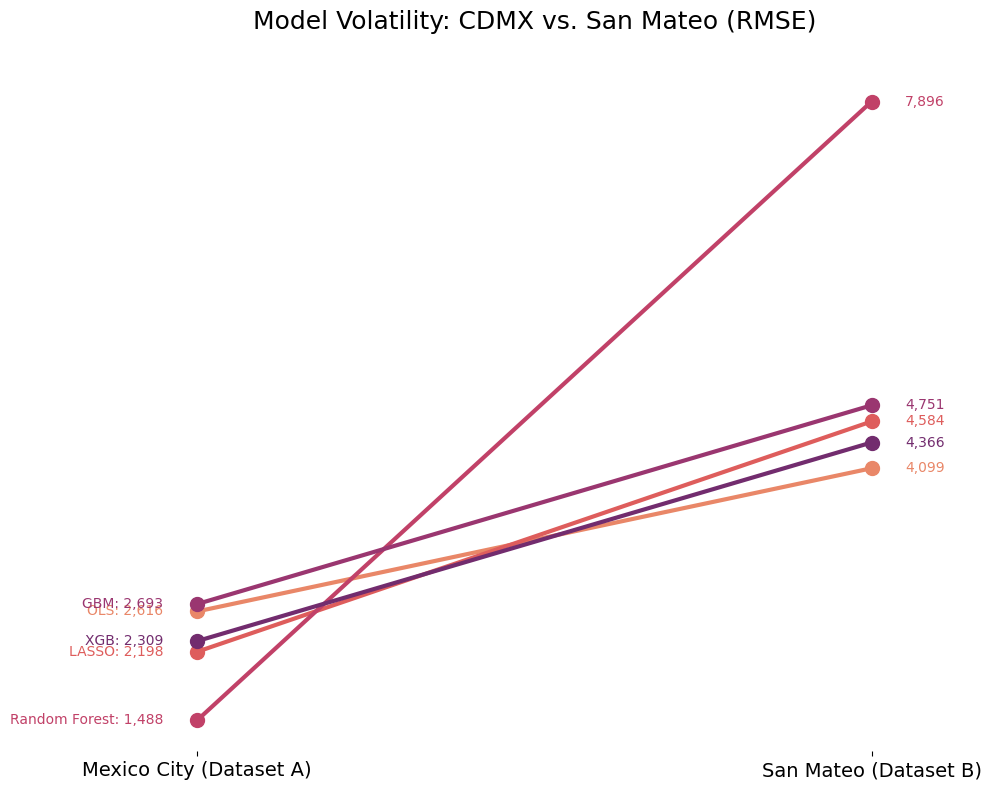

In [ ]:
plt.figure(figsize=(10, 8), facecolor='white')
ax = plt.subplot(111)
colors = sns.color_palette("flare", n_colors=len(final_results))

# Plot each model's slope
for i, row in final_results.iterrows():
    # Plot line
    plt.plot([0, 1], [row['CV RMSE Dataset A'], row['CV RMSE Dataset B']], 
             marker='o', color=colors[i], linewidth=3, markersize=10, label=row['Model'])
    
    # Label the lines on the left (CDMX)
    plt.text(-0.05, row['CV RMSE Dataset A'], f"{row['Model']}: {row['CV RMSE Dataset A']:,.0f}", 
             ha='right', va='center', color=colors[i])
    
    # Label the lines on the right (San Mateo)
    plt.text(1.05, row['CV RMSE Dataset B'], f"{row['CV RMSE Dataset B']:,.0f}", 
             ha='left', va='center', color=colors[i])

# Formatting
plt.title('Model Volatility: CDMX vs. San Mateo (RMSE)', fontsize=18, pad=30)
plt.xticks([0, 1], ['Mexico City (Dataset A)', 'San Mateo (Dataset B)'], fontsize=14)
plt.yticks([]) # Hide Y axis to focus on the slopes
sns.despine(left=True, bottom=True, right=True, top=True)

plt.tight_layout()
plt.show()